In [3]:
#!pip install neptune-client
#!pip install jupyter_bokeh
#!pip install pandas_bokeh

In [25]:
import neptune
neptune.init('fenoch4real/mscamachinelearningproject', 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3ZjM1NDBjYS00NmJjLTQ0MDItOWQ5ZC1jYzA4NmU3MzM2YzIifQ==') # Credentials
neptune.create_experiment('great-idea') # Start logging context
neptune.log_metric('accuracy', 0.92) # Log things

https://app.neptune.ai/fenoch4real/mscamachinelearningproject/e/MSCAM-18


In [26]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [27]:
%matplotlib inline
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pandas_bokeh
from bokeh.io import output_notebook
output_notebook()
from bokeh.models.widgets import DataTable, TableColumn
from bokeh.models import ColumnDataSource

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

Loading BokehJS ...

In [28]:
RANDOM_SEED = 42

# Data description:
`age` :(numeric)

`job` : type of job (categorical: 'admin.','bluecollar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

`marital` : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

`education` (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

`default` : has credit in default? (categorical: 'no','yes','unknown')

`housing`: has housing loan? (categorical: 'no','yes','unknown')

`loan` : has personal loan? (categorical: 'no','yes','unknown')

### 1 - Data Preparation & Cleaning

Import the dataset

In [29]:
#Read data file
heart = pd.read_csv("data/heart_statlog_cleveland_hungary_final.csv")

In [30]:
#Sneak peek into the data values
heart.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [31]:
heart.tail()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
1185,45,1,1,110,264,0,0,132,0,1.2,2,1
1186,68,1,4,144,193,1,0,141,0,3.4,2,1
1187,57,1,4,130,131,0,0,115,1,1.2,2,1
1188,57,0,2,130,236,0,2,174,0,0.0,2,1
1189,38,1,3,138,175,0,0,173,0,0.0,1,0


In [32]:
#view Dataset structure
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   int64  
 1   sex                  1190 non-null   int64  
 2   chest pain type      1190 non-null   int64  
 3   resting bp s         1190 non-null   int64  
 4   cholesterol          1190 non-null   int64  
 5   fasting blood sugar  1190 non-null   int64  
 6   resting ecg          1190 non-null   int64  
 7   max heart rate       1190 non-null   int64  
 8   exercise angina      1190 non-null   int64  
 9   oldpeak              1190 non-null   float64
 10  ST slope             1190 non-null   int64  
 11  target               1190 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 111.7 KB


In [33]:
#Check statistical charateristics of the data
heart.describe()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
count,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000
mean,53.720168,0.763866,3.232773,132.153782,210.363866,0.213445,0.698319,139.732773,0.387395,0.922773,1.624370,0.528571
std,9.358203,0.424884,0.935480,18.368823,101.420489,0.409912,0.870359,25.517636,0.487360,1.086337,0.610459,0.499393
min,28.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,188.000000,0.000000,0.000000,121.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,229.000000,0.000000,0.000000,140.500000,0.000000,0.600000,2.000000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,269.750000,0.000000,2.000000,160.000000,1.000000,1.600000,2.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,1.000000


In [34]:
#Confirm to make sure no NA's
heart.isnull().sum()

age                    0
sex                    0
chest pain type        0
resting bp s           0
cholesterol            0
fasting blood sugar    0
resting ecg            0
max heart rate         0
exercise angina        0
oldpeak                0
ST slope               0
target                 0
dtype: int64

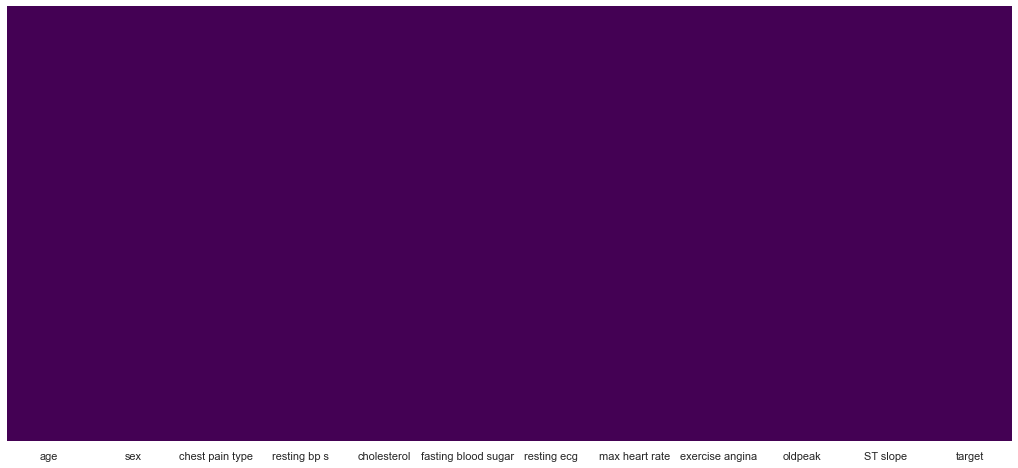

In [35]:
sns.set(rc={'figure.figsize':(18,8)})
sns.heatmap(heart.isnull(), yticklabels=False, cbar=False,cmap='viridis')
plt.show()

In [36]:
#Check for duplicated records
heart.duplicated().values.any()

True

In [37]:
#Count duplicates
heart.duplicated().values.sum()

272

In [38]:
#Drop duplicates
#heart.drop_duplicates(inplace=True)

In [39]:
# Changing column names
names = ['age', 'sex', 'chest_pain', 'resting_bp', 'cholesterol', 'fasting_bs', 'ecg_resting', 'max_hr', 'exercise_angina', 'ecg_oldpeak', 'ecg_slope', 'heart_disease']
heart.columns = names

In [40]:
# Creating lists for subsetting purposes
numeric_list = ['age', 'resting_bp', 'cholesterol', 'max_hr', 'ecg_oldpeak', 'heart_disease']
categorical_list = ['sex', 'chest_pain', 'fasting_bs', 'ecg_resting', 'exercise_angina', 'ecg_slope', 'heart_disease']
target = heart['heart_disease']

### 2 - Exploratory Data Analysis

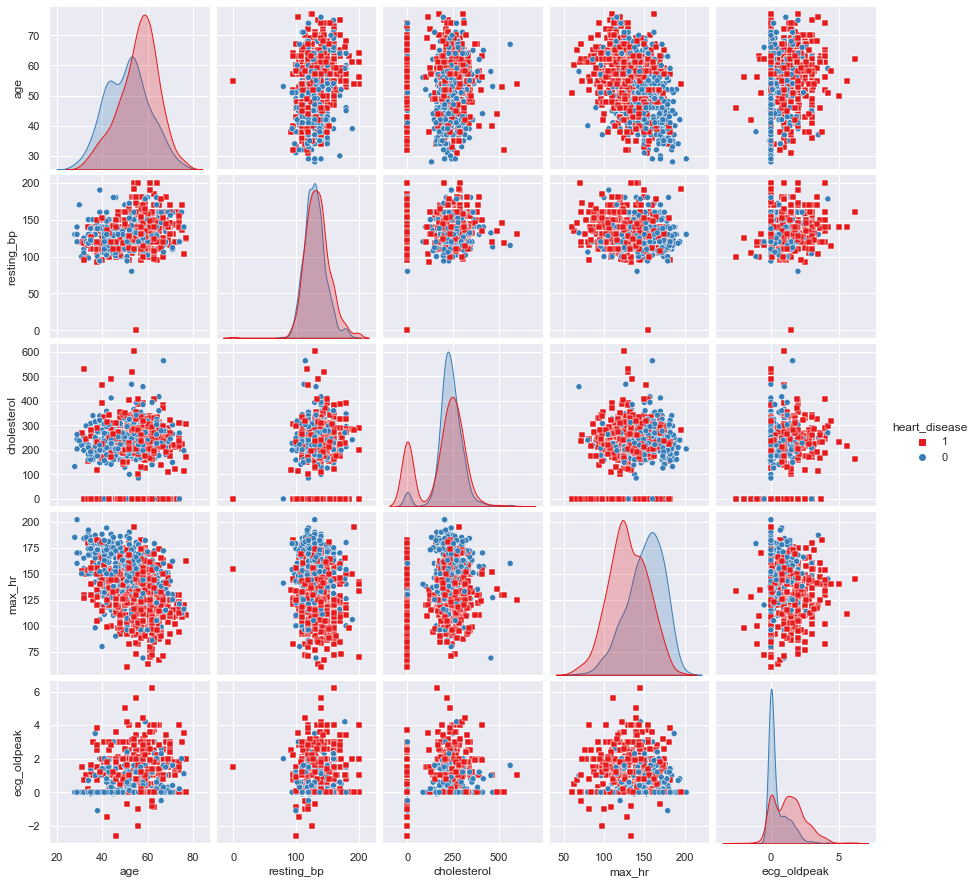

In [41]:
# Basic plots of numeric variables 
sns.pairplot(heart[numeric_list], 
             kind = "scatter", 
             hue = 'heart_disease',
             hue_order = [1, 0],
             markers = ["o", "s"],
             palette = 'Set1')
plt.show()

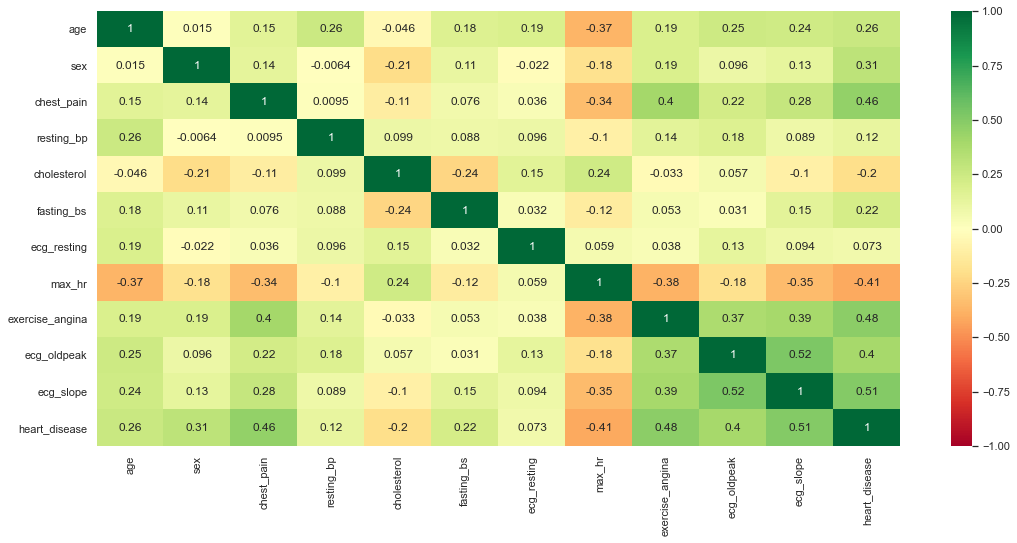

In [42]:
sns.set(rc={'figure.figsize':(18,8)})
sns.heatmap(heart.corr(),cmap='RdYlGn', vmin=-1, vmax=1 , annot=True) # cmap='coolwarm'
plt.show()

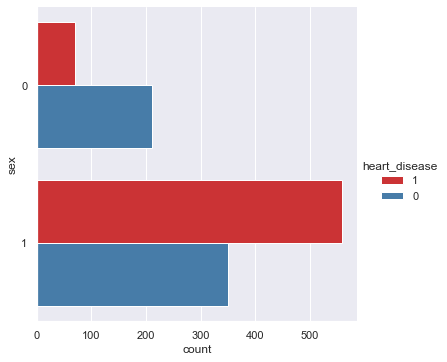

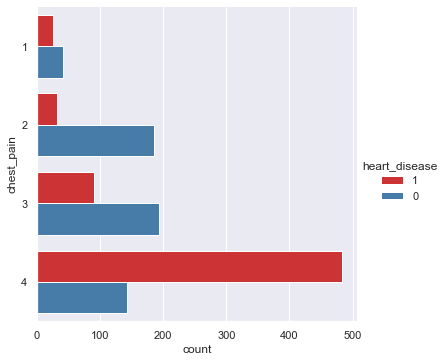

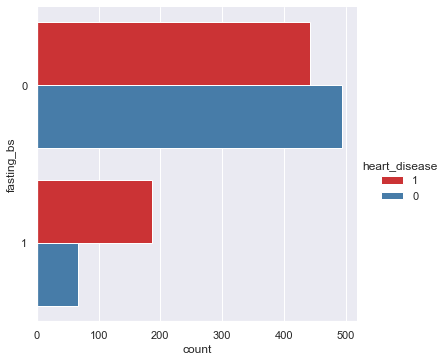

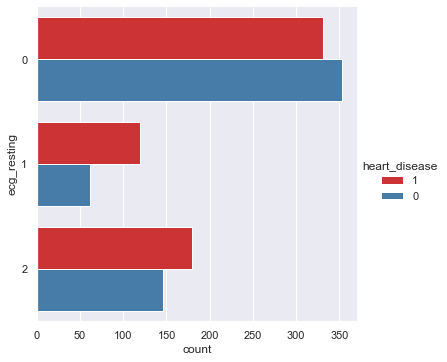

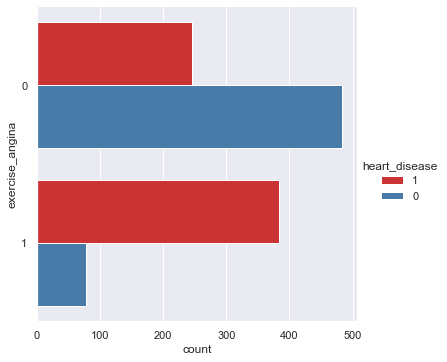

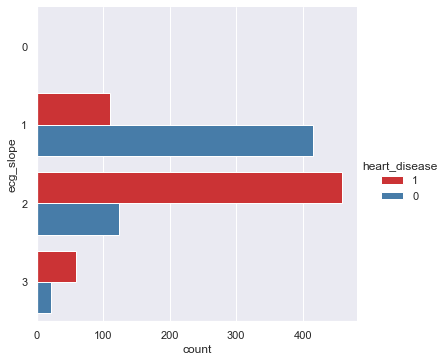

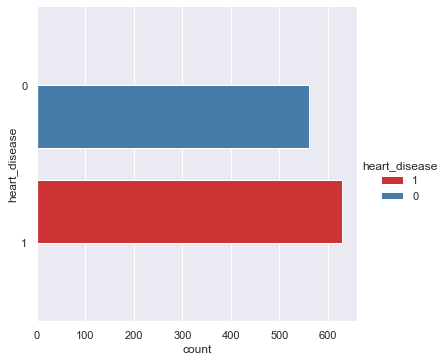

In [43]:
# Visualizing categorical variables

for i, name in enumerate(categorical_list):
  sns.catplot(y = categorical_list[i],
              hue = "heart_disease", 
              hue_order = [1, 0],
              kind = "count",
              palette = "Set1", 
              edgecolor = "1",
              data = heart)

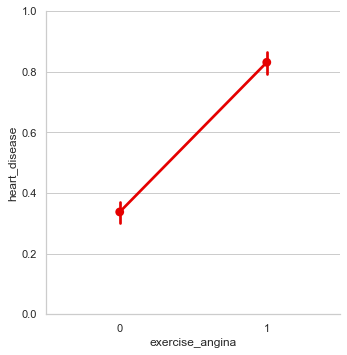

In [44]:
#Visualize the correlation of each predictor to the response
sns.set(style="whitegrid")
g = sns.PairGrid(data=heart, x_vars=['exercise_angina'], y_vars='heart_disease', height=5)
g.map(sns.pointplot, color=sns.xkcd_rgb["red"])
g.set(ylim=(0, 1))
plt.show()

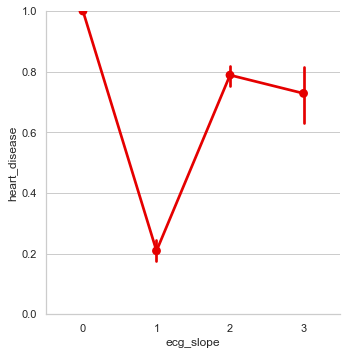

In [45]:
#Visualize the correlation of each predictor to the response
sns.set(style="whitegrid")
g = sns.PairGrid(data=heart, x_vars=['ecg_slope'], y_vars='heart_disease', height=5)
g.map(sns.pointplot, color=sns.xkcd_rgb["red"])
g.set(ylim=(0, 1))
plt.show()

In [46]:
#List top correlated variables with target
df_num_corr = heart.corr()['heart_disease'][:-1] # -1 because the latest row is target, take it out since it will correlate with itself
golden_features_list = df_num_corr[abs(df_num_corr) > 0.47].sort_values(ascending=False)
print("There is {} strongly correlated values with target:\n{}".format(len(golden_features_list), golden_features_list))

There is 2 strongly correlated values with target:
ecg_slope          0.505608
exercise_angina    0.481467
Name: heart_disease, dtype: float64


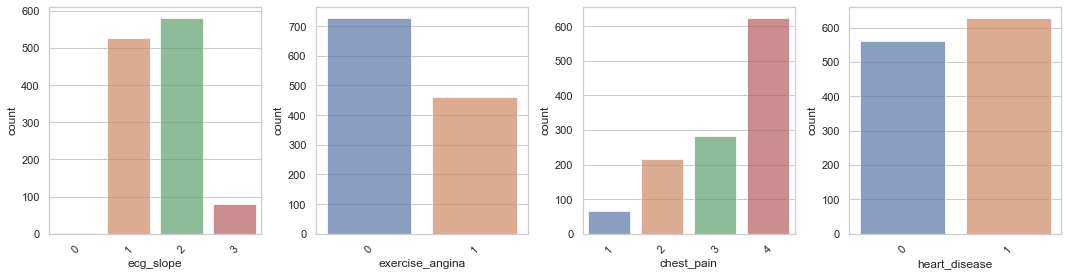

In [47]:
#Quantitative to Categorical Relationships - Visualize histogram relevant columns
features_to_analyse = ['ecg_slope','exercise_angina','chest_pain', 'heart_disease']
fig, axes = plt.subplots(round(len(features_to_analyse) / 4), 4, figsize=(15, 4))
for i, ax in enumerate(fig.axes):
    if i < len(features_to_analyse):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=features_to_analyse[i], alpha=0.7, data=heart[features_to_analyse], ax=ax)
fig.tight_layout()

### 3 - Feature Engineering

In [48]:
# Replacing zeroes with NaNs using the SimpleImputer function
heart_imputed = heart.copy()

heart_imputed['resting_bp'].replace(0, np.nan, inplace = True)
heart_imputed['cholesterol'].replace(0, np.nan, inplace = True)

imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')

heart_imputed.loc[:, ['resting_bp', 'cholesterol']] = imp_mean.fit_transform(heart_imputed[['resting_bp', 'cholesterol']])

In [49]:
# Creating training and test datasets
train, test = train_test_split(heart_imputed, 
                               test_size = 0.2, 
                               random_state = RANDOM_SEED)
X = train.drop('heart_disease', axis = 1)
y = train['heart_disease']

X_test = test.drop('heart_disease', axis = 1)
y_test = test['heart_disease']

In [50]:
# Creating training and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(X, y, 
                                                                train_size = 0.75, 
                                                                random_state = RANDOM_SEED)

In [51]:
# Check the shape of the training and validation sets
print('Shape of train data:', X_train.shape, y_train.shape)
print('Shape of validation data:', X_validation.shape, y_validation.shape)

Shape of train data: (714, 11) (714,)
Shape of validation data: (238, 11) (238,)


### 4 - Modeling - Supervised Learning

In [52]:
pipelines = {
    'randomforestclassifier' : make_pipeline(RandomForestClassifier(random_state=RANDOM_SEED)),
    'gradientboostingclassifier' : make_pipeline(GradientBoostingClassifier(random_state=RANDOM_SEED))
}

In [53]:
#Train base models
models ={}
for key in pipelines.keys():
    start_time = time.process_time()
    models[key] = pipelines[key].fit(X, y)
    print(key, 'is trained')
    end_time = time.process_time()
    duration = end_time - start_time
    print('Execution time : ', duration)
    print('    ')
    

randomforestclassifier is trained
Execution time :  0.2609679999999983
    
gradientboostingclassifier is trained
Execution time :  0.18193199999999976
    


In [54]:
#Test base model
for key in models.keys():
    start_time = time.process_time()
    pred = models[key].predict(X_test)
    print(key)
    print(classification_report(y_test, pred))
    print(confusion_matrix(y_test, pred))
    end_time = time.process_time()
    duration = end_time - start_time
    print('Execution time : ', duration)    
    print('  ')
    print('  ')
    print('  ')

randomforestclassifier
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       107
           1       0.95      0.97      0.96       131

    accuracy                           0.95       238
   macro avg       0.95      0.95      0.95       238
weighted avg       0.95      0.95      0.95       238

[[100   7]
 [  4 127]]
Execution time :  0.0336330000000018
  
  
  
gradientboostingclassifier
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       107
           1       0.92      0.94      0.93       131

    accuracy                           0.92       238
   macro avg       0.92      0.92      0.92       238
weighted avg       0.92      0.92      0.92       238

[[ 96  11]
 [  8 123]]
Execution time :  0.008839000000001818
  
  
  


In [55]:
#Perfrom cross-validation on base models - Classification
for key in models.keys():
    start_time = time.process_time()
    print(key)
    accuracies = cross_val_score(estimator = models[key], X = X, y = y, cv = 10)
    print("Training Accuracy: {:.2f} %".format(accuracies.mean()*100))
    print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

    var_name = ['age',	'sex',	'chest_pain',	'resting_bp',	'cholesterol',	'fasting_bs',	'ecg_resting',	'max_hr',	'exercise_angina',	'ecg_oldpeak',	'ecg_slope']
    #var_description = [ 'Description','Description','Description','Description','Description','Description','Description','Description','Description','Description','Description']

    # plot feature importance
    var_importance = models[key].named_steps[key].feature_importances_
    
    final_model_results = pd.DataFrame({'name': var_name,
                                    #'description': var_description,
                                    'importance': var_importance}).sort_values(by=['importance'],ascending=False) 
    #Create Bokeh-Table with DataFrame:
    data_table = DataTable(
    columns=[TableColumn(field=Ci, title=Ci) for Ci in final_model_results.columns],
    source=ColumnDataSource(final_model_results),
    height=300)

    # Create variable importance plot:
    plot_imp_rf = final_model_results.plot_bokeh.bar(
    x='name', xlabel='Predictor Variables',y='importance',ylabel='Importance',title='Variable Importance',
    show_figure=False,alpha=0.6)
    plot_imp_rf.xaxis.major_label_orientation = "vertical"

    # Combine Table and plot via grid layout:
    pandas_bokeh.plot_grid([[data_table, plot_imp_rf]], plot_width=400, plot_height=350)
    end_time = time.process_time()
    duration = end_time - start_time
    print('Execution time : ', duration)
    print('  ')
    print('  ')
    print('  ')
    print('  ')

randomforestclassifier
Training Accuracy: 90.23 %
Standard Deviation: 2.80 %


Execution time :  2.974602000000001
  
  
  
  
gradientboostingclassifier
Training Accuracy: 88.23 %
Standard Deviation: 2.79 %


Execution time :  1.847916999999999
  
  
  
  


In [56]:
#Perfrom Grid Search
# Create a hyperparameter grid for Random Forest
rf_hyperparameters = {
    'randomforestclassifier__n_estimators' : [100, 200],
    'randomforestclassifier__max_features' : ['auto', 0.3, 0.6] 
}

# Create a hyperparameter grid for Gradient Booster
gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators' : [100, 200],
    'gradientboostingclassifier__learning_rate' : [0.05, 0.1, 0.2],
    'gradientboostingclassifier__max_depth' : [1, 3, 5] 
}

In [57]:
# Create the hyperparameter_grids dictionary
hyperparameters = {
    'randomforestclassifier' : rf_hyperparameters,
    'gradientboostingclassifier' : gb_hyperparameters
}
for key in ['randomforestclassifier','gradientboostingclassifier'] :
    if key in hyperparameters :
        if type(hyperparameters[key]) is dict :
            print(key, 'was found, and it is a grid.')
        else :
            print(key, 'was found, but it is not a grid.')
    else :
        print(key, 'was not found.')

randomforestclassifier was found, and it is a grid.
gradientboostingclassifier was found, and it is a grid.


In [58]:
# Create a dictionary containing your untrained models
pipelines.keys()

dict_keys(['randomforestclassifier', 'gradientboostingclassifier'])

In [59]:
#Build Parameter grid
models ={}
for key in pipelines.keys():
    models[key] = GridSearchCV(pipelines[key], hyperparameters[key], cv=10)
    
models.keys()

dict_keys(['randomforestclassifier', 'gradientboostingclassifier'])

In [60]:
# Write a for loop to train your models
for key in models.keys():
    start_time = time.process_time()
    models[key].fit(X, y)
    print(key, 'is trained and tuned')
    print(models[key].best_params_, 'best Parameter')
    print(models[key].score(X, y), ' - score on train data')#Calculates Accuracy ie. comparing predicted y_train with actual y_train
    print(models[key].score(X_test, y_test), ' - score on test data')#Calculates Accuracy ie. comparing predicted y_test with actual y_test
    end_time = time.process_time()
    duration = end_time - start_time
    print('Execution time : ', duration)    
    print('  ')
    print('  ')
    print('  ')

randomforestclassifier is trained and tuned
{'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__n_estimators': 200} best Parameter
1.0  - score on train data
0.957983193277311  - score on test data
Execution time :  26.599238
  
  
  
gradientboostingclassifier is trained and tuned
{'gradientboostingclassifier__learning_rate': 0.05, 'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__n_estimators': 200} best Parameter
0.9978991596638656  - score on train data
0.9495798319327731  - score on test data
Execution time :  51.243722
  
  
  


In [61]:
# Write a for loop that tests calculates and prints each model's AUROC
from sklearn.metrics import roc_curve, auc
for key in models.keys():
    start_time = time.process_time()
    pred = models[key].predict(X_test)
    fpr, tpr, threshholds = roc_curve(y_test, pred)
    print(key)
    print('AUROC =', round(auc(fpr,tpr),4))
    print(classification_report(y_test, models[key].predict(X_test)))
    print(confusion_matrix(y_test, models[key].predict(X_test)))
    var_name = ['age',	'sex',	'chest_pain',	'resting_bp',	'cholesterol',	'fasting_bs',	'ecg_resting',	'max_hr',	'exercise_angina',	'ecg_oldpeak',	'ecg_slope']
    #var_description = [ 'Description','Description','Description','Description','Description','Description','Description','Description','Description','Description','Description']

    var_importance = models[key].best_estimator_.named_steps[key].feature_importances_
    final_model_results = pd.DataFrame({'name': var_name,
                                    #description': var_description,
                                    'importance': var_importance}).sort_values(by=['importance'],ascending=False)   
    #Create Bokeh-Table with DataFrame:
    data_table = DataTable(columns=[TableColumn(field=Ci, title=Ci) for Ci in final_model_results.columns],source=ColumnDataSource(final_model_results),height=300)

    # Create variable imporatnce plot
    plot_imp = final_model_results.plot_bokeh.bar(
    x='name', xlabel='Predictor Variables',y='importance',ylabel='Importance',title='Variable Importance',show_figure=False,alpha=0.6)
    plot_imp.xaxis.major_label_orientation = "vertical"

    # Combine Table and plot via grid layout:
    pandas_bokeh.plot_grid([[data_table, plot_imp]], plot_width=400, plot_height=350)
    end_time = time.process_time()
    duration = end_time - start_time
    print('Execution time : ', duration)
    print('  ')
    print('  ')
    print('  ')

randomforestclassifier
AUROC = 0.9558
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       107
           1       0.95      0.98      0.96       131

    accuracy                           0.96       238
   macro avg       0.96      0.96      0.96       238
weighted avg       0.96      0.96      0.96       238

[[100   7]
 [  3 128]]


Execution time :  0.27668699999999546
  
  
  
gradientboostingclassifier
AUROC = 0.9482
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       107
           1       0.95      0.96      0.95       131

    accuracy                           0.95       238
   macro avg       0.95      0.95      0.95       238
weighted avg       0.95      0.95      0.95       238

[[100   7]
 [  5 126]]


Execution time :  0.15344899999999484
  
  
  
